In [1]:
import numpy as np
def read_csv ( csv_path ):
    np_path_XYs = np . genfromtxt ( csv_path , delimiter = ',')
    path_XYs = []
    for i in np . unique ( np_path_XYs [: , 0]):
        npXYs = np_path_XYs [ np_path_XYs [: , 0] == i ][: , 1:]
        XYs = []
        for j in np . unique ( npXYs [: , 0]):
            XY = npXYs [ npXYs [: , 0] == j ][: , 1:]
            XYs . append ( XY )
            path_XYs . append ( XYs )
    return path_XYs

import numpy as np
import matplotlib . pyplot as plt
def plot ( paths_XYs ):
    fig , ax = plt . subplots ( tight_layout = True , figsize =(8 , 8))
    for i , XYs in enumerate ( paths_XYs ):
        for XY in XYs :
            ax . plot ( XY [: , 0] , XY [: , 1]  , linewidth =2)
    ax . set_aspect ('equal')
    plt . show ()


In [2]:
import numpy as np
import cv2
import csv

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def hough_transform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    # Detect circles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50, param2=30, minRadius=0, maxRadius=0)
    
    return lines, circles

def detect_shapes(path_XYs):
    detected_shapes = []
    for shape in path_XYs:
        for path in shape:
            if len(path) > 1:
                # Create an empty image
                img = np.zeros((500, 500, 3), dtype=np.uint8)
                for point in path:
                    cv2.circle(img, (int(point[0]), int(point[1])), 1, (255, 255, 255), -1)
                
                lines, circles = hough_transform(img)
                
                if lines is not None:
                    detected_shapes.append(('line', path))
                elif circles is not None:
                    detected_shapes.append(('circle', path))
                else:
                    # Detect contours
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    contours, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                    for contour in contours:
                        epsilon = 0.02 * cv2.arcLength(contour, True)
                        approx = cv2.approxPolyDP(contour, epsilon, True)
                        if len(approx) == 10:  # Assuming a star has 10 vertices
                            detected_shapes.append(('star', path))
                        else:
                            detected_shapes.append(('unknown', path))
    
    return detected_shapes

def regularize_shapes(detected_shapes):
    regularized_shapes = []
    for shape_type, path in detected_shapes:
        if shape_type == 'line':
            # Replace with a straight line
            x_coords = [point[0] for point in path]
            y_coords = [point[1] for point in path]
            line = np.polyfit(x_coords, y_coords, 1)
            fit_line = np.poly1d(line)
            regularized_path = [[x, fit_line(x)] for x in x_coords]
            regularized_shapes.append(regularized_path)
        elif shape_type == 'circle':
            # Replace with a perfect circle
            center_x = np.mean([point[0] for point in path])
            center_y = np.mean([point[1] for point in path])
            radius = np.mean([np.sqrt((point[0] - center_x)**2 + (point[1] - center_y)**2) for point in path])
            regularized_path = [[center_x + radius * np.cos(theta), center_y + radius * np.sin(theta)] for theta in np.linspace(0, 2 * np.pi, len(path))]
            regularized_shapes.append(regularized_path)
        elif shape_type == 'star':
            # Replace with a perfect star
            center_x = np.mean([point[0] for point in path])
            center_y = np.mean([point[1] for point in path])
            max_radius = np.max([np.sqrt((point[0] - center_x)**2 + (point[1] - center_y)**2) for point in path])
            regularized_path = []
            for i in range(10):
                angle = i * np.pi / 5
                if i % 2 == 0:
                    r = max_radius
                else:
                    r = max_radius / 2
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                regularized_path.append([x, y])
            regularized_path.append(regularized_path[0])  # Ensure the star is closed
            regularized_shapes.append(regularized_path)
        else:
            regularized_shapes.append(path)  # Unknown shapes remain unchanged
    
    return regularized_shapes

def write_csv(output_path, regularized_shapes):
    with open(output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for shape_id, shape in enumerate(regularized_shapes):
            for point in shape:
                writer.writerow([shape_id, 0, point[0], point[1]])

csv_path = 'problems\isolated.csv'
output_path = 'output.csv'

# Step 1: Read and parse CSV
path_XYs = read_csv(csv_path)

# Step 2: Detect shapes
detected_shapes = detect_shapes(path_XYs)

# Step 3: Regularize shapes
regularized_shapes = regularize_shapes(detected_shapes)

# Step 4: Write output CSV
write_csv(output_path, regularized_shapes)


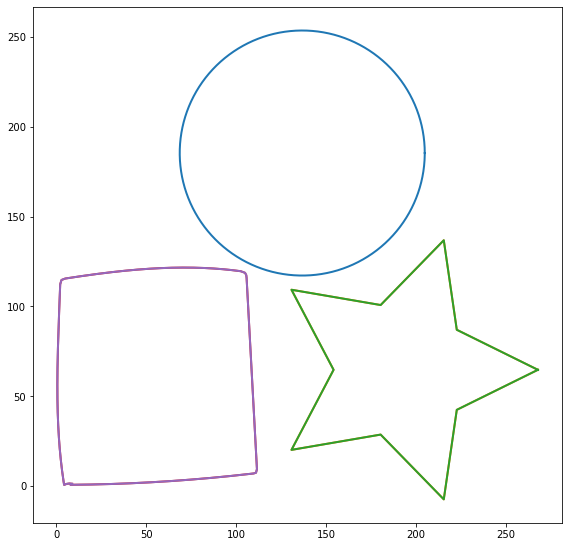

In [3]:
plot(read_csv(output_path))